In [1]:
from models.AtlasNet import AtlasNet_create_model, AtlasNet_step
from modules.emd import EMDModule
import torch
import os
import h5py
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

# Create Args for AtlasNet creation

In [2]:
prop = {
    'code_nfts' : 1024,
    'npts': 2048,
    'nb_primitives': 4
}
args = type('obj', (object,), prop)

In [3]:
net = AtlasNet_create_model(args)

Total number of parameters: 8060744
DataParallel(
  (module): AtlasNet(
    (encoder): Sequential(
      (0): PointNetfeat(
        (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
        (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
        (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Linear(in_features=1024, out_features=1024, bias=True)
      (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
    (decoder): ModuleList(
      (0): PointGenCon(
        (conv1): Conv1d(1026, 1026, kernel_size=(1,), stride=(1,))
        (conv2): Conv1d(1026, 513, kernel_size=(1,), stride=(1,))
        (conv3): Conv

In [4]:
#we need it?
emd_mod = EMDModule()
step = AtlasNet_step

# Load Params

In [21]:
path = "results/shapenetComplete/AtlasNet_chamfer_npts2116_NBP4_lr0.0100_adagrad_B32/models/model_300.pth.tar"
checkpoint = torch.load(path)
torch.save(checkpoint["state_dict"], "model_300.pth")

In [6]:
net.load_state_dict(checkpoint["state_dict"])

# Load Data

In [10]:
dataset_path = "/media/mint/Barracuda/Datasets/Completion3D/shapenet/"
data_type = "partial" # or gt
folder = "02691156"
env = "train"
file = "1a04e3eab45ca15dd86060f189eb133.h5"
# env = "val"
# file = "66b9ccf5842ed7f79330265a9fff38de.h5"
#folder = "02958343"
#file = "5ab4bb1c287b012393e3fa1f41b06fc9.h5"

d_path = os.path.join(dataset_path, env, data_type, folder, file)

In [11]:
f = h5py.File(d_path, 'r')
cloud_data = np.array(f['data'])
f.close()

d = cloud_data.astype(np.float64)

In [12]:
print(d.shape)

(2048, 3)


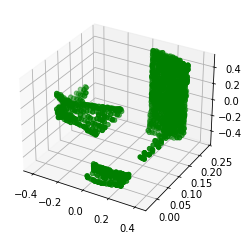

In [13]:
plt3d = plt.figure().gca(projection='3d')
xs, ys, zs = [], [], []
for i in d:
    x = i[0]
    xs.append(x)
    y = i[1]
    ys.append(y)
    z = i[2]
    zs.append(z)
    
plt3d.scatter(xs , ys, zs,  color='green')

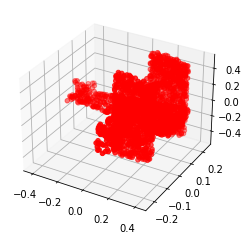

In [14]:
d_path = os.path.join(dataset_path, env, 'gt', folder, file)
f = h5py.File(d_path, 'r')
cloud_data = np.array(f['data'])
f.close()

d_g = cloud_data.astype(np.float64)

plt3d = plt.figure().gca(projection='3d')
xs, ys, zs = [], [], []
for i in d_g:
    x = i[0]
    xs.append(x)
    y = i[1]
    ys.append(y)
    z = i[2]
    zs.append(z)
    
plt3d.scatter(xs , ys, zs,  color='red')

# Predict

In [15]:
grain = int(np.sqrt(args.npts/args.nb_primitives))
grain = grain*1.0
n = ((grain + 1)*(grain + 1)*args.nb_primitives)
if n < args.npts:
    grain += 1

In [16]:
#generate regular grid
vertices = []
for i in range(0,int(grain + 1 )):
    for j in range(0,int(grain + 1 )):
        vertices.append([i/grain,j/grain])

grid = [vertices for i in range(0,args.nb_primitives)]

In [17]:
inp = torch.from_numpy(d).float().cuda()
inp = inp.permute(1, 0).unsqueeze(0)
inp = torch.cat(32*[inp])
print(inp.shape)

torch.Size([2, 3, 2048])


In [18]:
outputs = net(inp, grid)

In [19]:
print(outputs.shape)

torch.Size([2, 2116, 3])


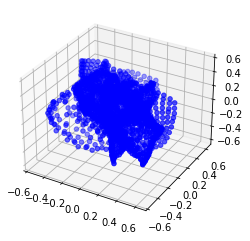

In [20]:
plt3d = plt.figure().gca(projection='3d')
xs, ys, zs = [], [], []
for i in outputs[0].squeeze(0):
    x = i[0].item()
    xs.append(x)
    y = i[1].item()
    ys.append(y)
    z = i[2].item()
    zs.append(z)
    
plt3d.scatter(xs , ys, zs,  color='blue')